## Imports

In [1]:
# import matplotlib
# matplotlib.use('Qt5Agg')  # Set the backend to a valid option like 'TkAgg'
import matplotlib.pyplot as plt
import os
# print(os.environ.get('MPLBACKEND'))
import numpy as np
from PIL import Image
import time
import pandas as pd
import math

In [36]:
def abrirImagenesEscaladas( carpeta, escala=32 ):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            if file.endswith('DS_Store'):
                continue
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [37]:
# Data
if(True):
    img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/')
    img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/') # NO FUNCIONA :(
    img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/')
    img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/')

    data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)


Optimizar los parametros de la funcion f para el conjunto de datos de entrenamiento.

In [4]:
def balancear_datos(imagenes_entrenamiento):

    img_train_sin_neumonia = imagenes_entrenamiento[0]
    img_train_neumonia =imagenes_entrenamiento[1]
    img_test_sin_neumonia =imagenes_entrenamiento[2]
    img_test_neumonia = imagenes_entrenamiento[3]

    # MAX NUMBER OF IMAGES
    n_train = min(len(img_train_sin_neumonia), len(img_train_neumonia))
    n_test = min(len(img_test_sin_neumonia), len(img_test_neumonia))

    # BALANCE
    img_train_sin_neumonia = img_train_sin_neumonia[:n_train]
    img_train_neumonia = img_train_neumonia[:n_train]
    img_test_sin_neumonia = img_test_sin_neumonia[:n_test]
    img_test_neumonia = img_test_neumonia[:n_test]

    
    return (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)

In [5]:
data = balancear_datos(data)

In [6]:
train_sin, train_con, test_sin, test_con = data
training_data = (train_sin,train_con)
testing_data = (test_sin,test_con)

## Ejercicio 1: Derivadas Parciales

Derivada con respecto a $\mathbf{w}$:

$
\frac{\partial L}{\partial \mathbf{w}} = \sum_{i=1}^{N} \left( \left(1 + \tanh(\mathbf{w} \cdot \mathbf{i} + b)\right)^2 - d_i \right) \left(1 - \tanh^2(\mathbf{w} \cdot \mathbf{i} + b)\right) \mathbf{i}
$

Derivada con respecto a $b$:

$
\frac{\partial L}{\partial b} = \sum_{i=1}^{N} \left( \left(1 + \tanh(\mathbf{w} \cdot \mathbf{i} + b)\right)^2 - d_i \right) \left(1 - \tanh^2(\mathbf{w} \cdot \mathbf{i} + b)\right)
$



In [7]:
def L_w(i,w,b,d):
    """Derivada de L con respecto a W

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Vector: Gradiente de la probabilidad con respecto a los pesos
    """
    # t0=tanh(b+W⊤⋅i)
    #return: (1−t0^2)⋅((1+t0)/2−d)⋅i
    
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d) * i

In [8]:
def L_b(i,w,b,d):
    """Derivada de l con respecto a b 

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Float: Gradiente de la probabilidad con respecto al bias
    """
    #t0=tanh(b+W⊤⋅i)
    #(1−t0^2)⋅((1+t0)/2−d)   
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d)

In [9]:
def F(i,w,b):
    """Funcion tanh 

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        probabolidad: 0 < p < 1: Probabilidad de que la imagen sea un 1 (Tiene neumonia)
    """
    tan = np.tanh(np.dot(w,i)+b)
    return (tan + 1)/2

In [10]:
def error_cuadratico(data,w_res, b_res):
    error = 0
    len_data = len(data[0]) + len(data[1])     
                
    # Testing con imágenes sin neumonía
    label = 0
    for i in data[0]: 
        error += (F(i,w_res, b_res) - label)**2 

    # Testing con imágenes con neumonía
    label = 1
    for i in data[1]:
        error += (F(i,w_res, b_res) - label)**2 
    
    return error/len_data

## Ejercicio 2

Implementar el metodo de descenso por gradiente.

In [11]:
def descenso_gradiente(w,b,gradiente_w, gradiente_b, alpha):
    """Calcula el descenso por gradiente de w y b 

    Args:
        imagenes_entrenamiento (List): Lista de imagenes de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate

    Returns:
        Tuple: Pesos y bias actualizados

    """
    w = w - alpha * gradiente_w
    b = b - alpha * gradiente_b
    return w,b


## Ejercicio 3

Calcular el error cuadratico durante la optimizacion para el conjunto de entrenamiento y para el conjunto de testing. Generar las visualizaciones correspondientes.

In [12]:
def train(datos, alpha=0.005, epochs = 5,seed = 42,plot_graph=True):
    """Metodo de entrenamiento atraves del descanso de gradiente por la funcion tanh

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
        
    datos_sin_neumonia = np.array(datos[0])
    datos_con_neumonia = np.array(datos[1])

    # inicioamos con pesos aleatorios
    # set numpy seed
    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0]) * 0.01
    b = np.random.randn(1) * 0.01
   
    len_data = len(datos_sin_neumonia) + len(datos_con_neumonia)
   
    errores = []
   
    
    for epoch in range(epochs):  
        
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
       
            
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
        
        # Promediar los gradientes acumulados
        gradiente_w /= (len_data)
        gradiente_b /= (len_data)
        
        # Actualización de los parámetros
        w, b = descenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
        error_cuadratico = error/len_data
        # Almacenar el error cuadrático promedio para visualización
        errores.append(error_cuadratico)
          
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        # Mostrar el error de la epoch actual
        print(f"\rError Cuadratico: {error_cuadratico}",end='',)
    
    if plot_graph:
        plt.plot(errores)
        plt.xlabel('Epoch')
        plt.ylabel('Error Cuadrático')
        plt.title('Error Cuadrático durante el Entrenamiento')
        plt.show()

    return w,b

In [13]:
def test(w,b,datos):
    """ Devuelve el porcentaje de de imagenes correctas que clasifico la funcion encontrada
    
    Args:
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 

    Returns:
        Float: Accuracy
    """
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    correctos = 0
    
    for i in datos_sin_neumonia:
        if F(i,w,b) < 0.5:
            correctos += 1
            
    for i in datos_con_neumonia:
        if F(i,w,b) >= 0.5:
            correctos += 1
            
    return correctos/(len(datos_sin_neumonia)+len(datos_con_neumonia))

[0.15522437]

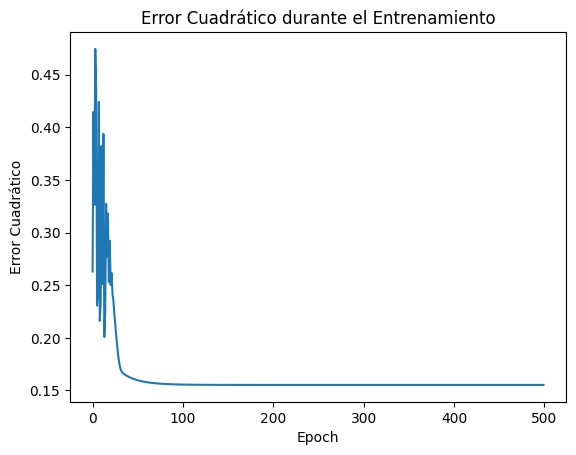

Procentaje de datos correctos: 0.8595255744996294%


In [15]:
# Training Data: nos devuelve el w y b munimo, con alpha 0.05 para probar
w_res, b_res = train(
    training_data,
    alpha=0.05,
    epochs = 500,
    seed = 42,
    plot_graph=True
    )

print(f"Procentaje de datos correctos: {test(w_res,b_res,training_data)}%")

In [16]:
# Testing Data: calculamos el error cuadratico con los w y b resultantes del training
error_total = error_cuadratico(testing_data,w_res,b_res)
    
print(f"Error cuadratico: {error_total}")
print(f"Procentaje de datos correctos: {test(w_res,b_res,testing_data)}%")

Error cuadratico: [0.17814429]
Procentaje de datos correctos: 0.7991452991452992%


## Ejercicio 4
Analizar el impacto del parametro α en la convergencia del metodo. Tomar un rango
de 5 valores posibles y analizar la convergencia para el conjunto de testing para los distintos valores de α.

In [17]:
def analizar_convergencia(errores):
    if len(errores) < 2:
        return float('inf') 
    return abs(errores[-1] - errores[-2]) / errores[-2]

In [18]:
def train_test_convergencia(datos, alpha,seed,diferencia_minima, plot_graph=True):
    """Usamos el mismo test de antes pero ahora probamos convergencia 

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
       
    datos_sin_neumonia = np.array(datos[0])
    datos_con_neumonia = np.array(datos[1])

    # inicioamos con pesos aleatorios
    # set numpy seed
    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0]) * 0.01
    b = np.random.randn(1) * 0.01
   
    len_data = len(datos_sin_neumonia) + len(datos_con_neumonia)
   
    errores = []
    contador = 0
    
    while(True):  
        
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
       
            
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
        
        # Promediar los gradientes acumulados
        gradiente_w /= (len_data)
        gradiente_b /= (len_data)
        
        # Actualización de los parámetros
        w, b = descenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
        error_cuadratico = error/len_data
        
        # Almacenar el error cuadrático promedio para visualización
        errores.append(error_cuadratico)
          
        
        diferencia = analizar_convergencia(errores)
        
        # Mostrar el error de la epoch actual
        print(f"\rError: {errores[-1]}  Diferencia: {diferencia}",end='',)
        
        if diferencia < diferencia_minima:
            print(f"\nConvergio en el epoch: {contador} con aplha: {alpha}")
            break
        
        
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        contador += 1
       
        
    if plot_graph:
        plt.plot(errores)
        plt.xlabel('Epoch')
        plt.ylabel('Error Cuadrático')
        plt.title('Error Cuadrático durante el Entrenamiento')
        plt.show()

    return w,b,contador,alpha

Error: [0.1556775]  Diferencia: [8.91444649e-16]]
Convergio en el epoch: 591 con aplha: 3.41680921775017e-15


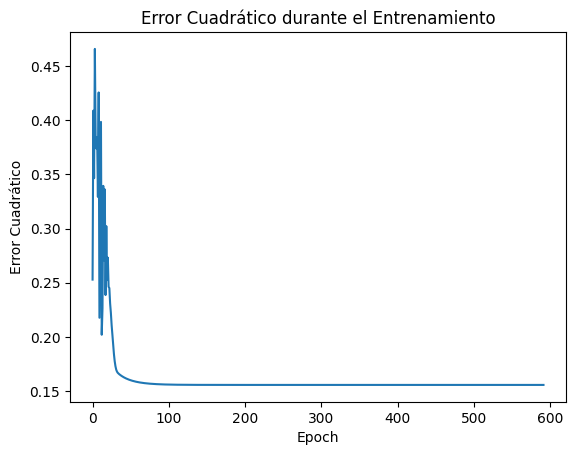

Error: [0.20875615]  Diferencia: [5.31827703e-16]
Convergio en el epoch: 579 con aplha: 1.2646415957661875e-15


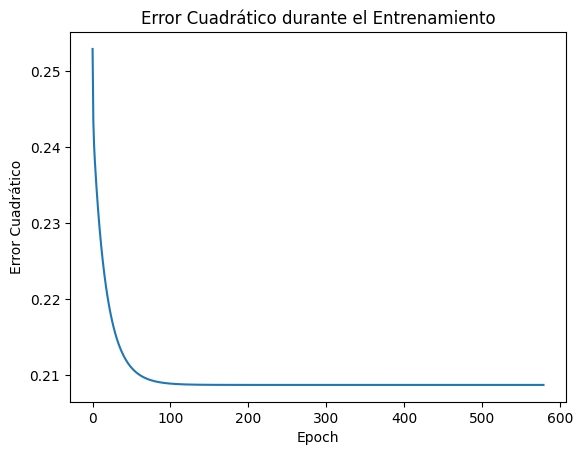

Error: [0.22468322]  Diferencia: [7.41192213e-16]
Convergio en el epoch: 553 con aplha: 2.3995164359858582e-15


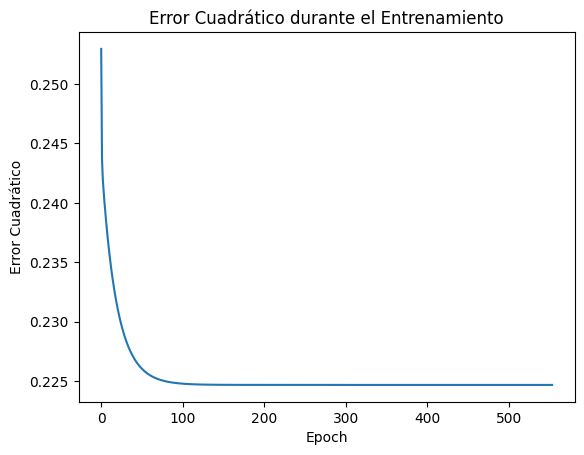

Error: [0.23977664]  Diferencia: [4.63023839e-16]
Convergio en el epoch: 526 con aplha: 1.9169747034606602e-15


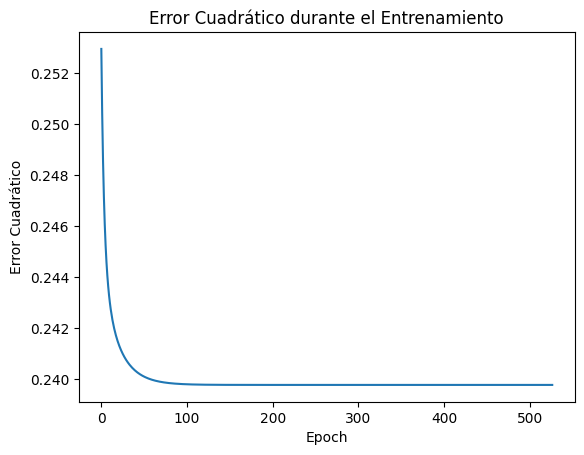

Error: [0.24227821]  Diferencia: [3.4368228e-16]]
Convergio en el epoch: 518 con aplha: 1.444766103853535e-15


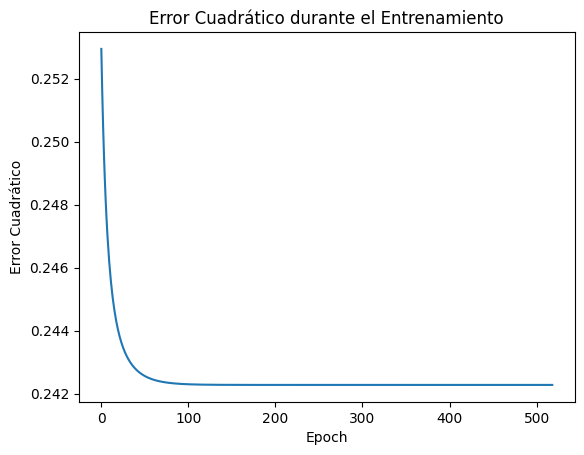

Error: [0.24864629]  Diferencia: [0.]1626745e-15]
Convergio en el epoch: 527 con aplha: 1.8211259682876268e-16


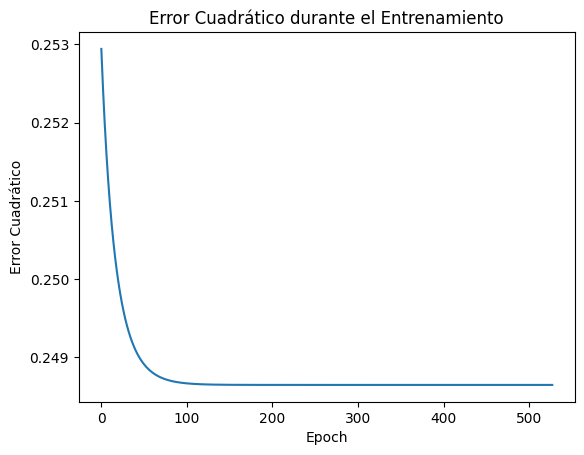

Error: [0.2505454]  Diferencia: [8.86244985e-16]]
Convergio en el epoch: 516 con aplha: 1.6008488685357729e-16


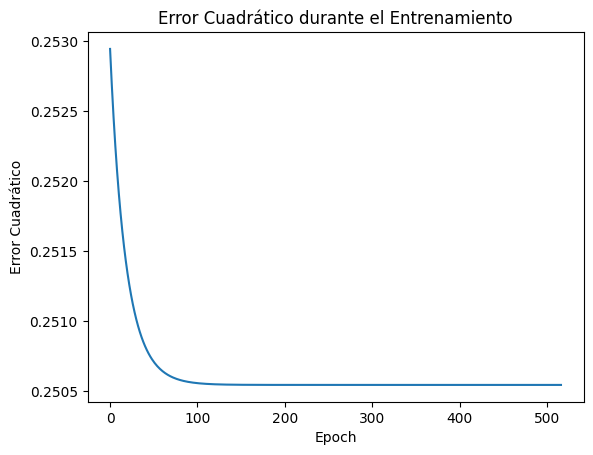

Error: [0.25241832]  Diferencia: [0.]3859387e-15]
Convergio en el epoch: 481 con aplha: 1.9277652346669755e-16


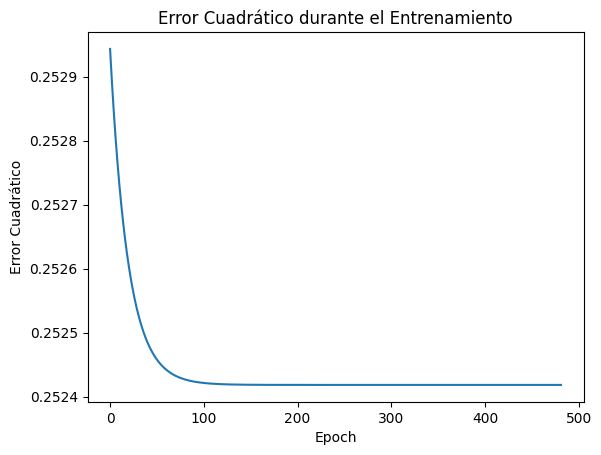

In [19]:
#Testing: Probamos con varios alphas para probar convergencia
alphas = [ 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
tiempo_ejecucion = []
epochs = []
alphas_nuevos_valores = []
porcentaje_correctitud = []
resultados_w_b = []


diferencia_min = 1e-15

for i in alphas:
    
    start_time = time.time()
    
    w_res, b_res, epoch, alpha = train_test_convergencia(
        training_data,
        alpha=i,
        seed = 40,
        diferencia_minima = diferencia_min,
        plot_graph=True
        )
    
    end_time = time.time()
    
    resultados_w_b.append((w_res,b_res))

    tiempo_ejecucion.append(end_time - start_time)
    epochs.append(epoch)
    alphas_nuevos_valores.append(alpha)
    porcentaje_correctitud.append(test(w_res,b_res,(test_sin,test_con)))
    

In [20]:
# Crear un DataFrame con los datos
data = {
    'Metric': ['tiempo_ejecucion', 'alphas_nuevos_valores'],
    **{alpha: [tiempo_ejecucion[i], alphas_nuevos_valores[i]] for i, alpha in enumerate(alphas)}
}

df = pd.DataFrame(data)

# Nombre del archivo con el valor de convergencia en el título
filename = f'Resultados_conv_training{diferencia_min:.0e}.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(filename, index=False)

print(f'Data saved to {filename}')

Data saved to Resultados_conv_training1e-15.csv


In [26]:
# Testing Data: calculamos el error cuadratico con los w y b resultantes del training para todos los alphas
errores_alphas = []
test_efectividad = []

for w_res,b_res in resultados_w_b:
    error = error_cuadratico(testing_data, w_res,b_res)
    errores_alphas.append(error)
    test_efectividad.append(test(w_res,b_res,testing_data))

    

### Graficos de training

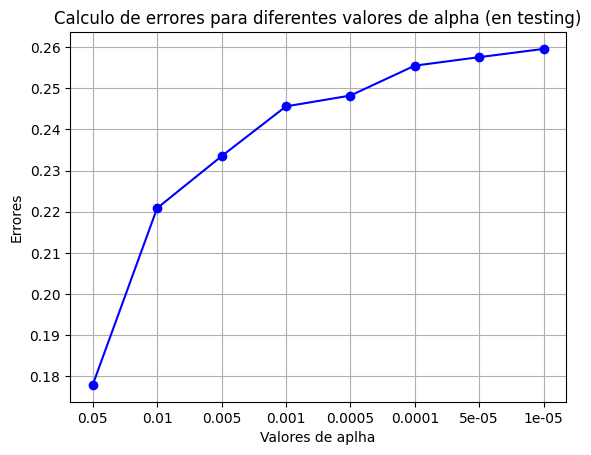

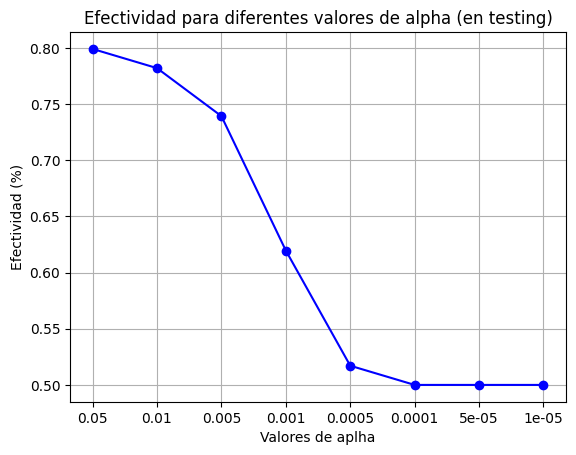

In [27]:
alphas_str = [str(alpha) for alpha in alphas]

plt.plot(alphas_str, errores_alphas, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Errores')
plt.title('Calculo de errores para diferentes valores de alpha (en testing)')

plt.grid(True) 
plt.show()

plt.plot(alphas_str, test_efectividad, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad para diferentes valores de alpha (en testing)')

plt.grid(True) 
plt.show()

### Graficos de training

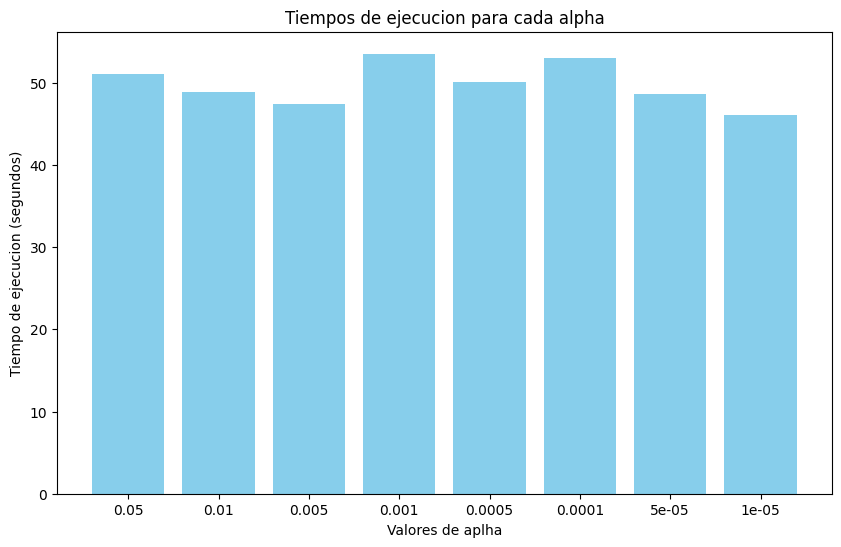

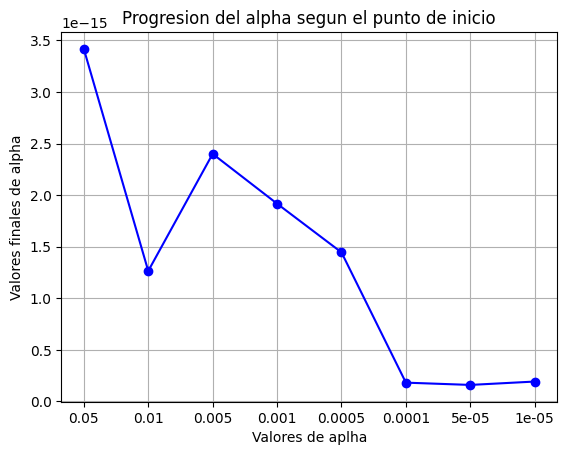

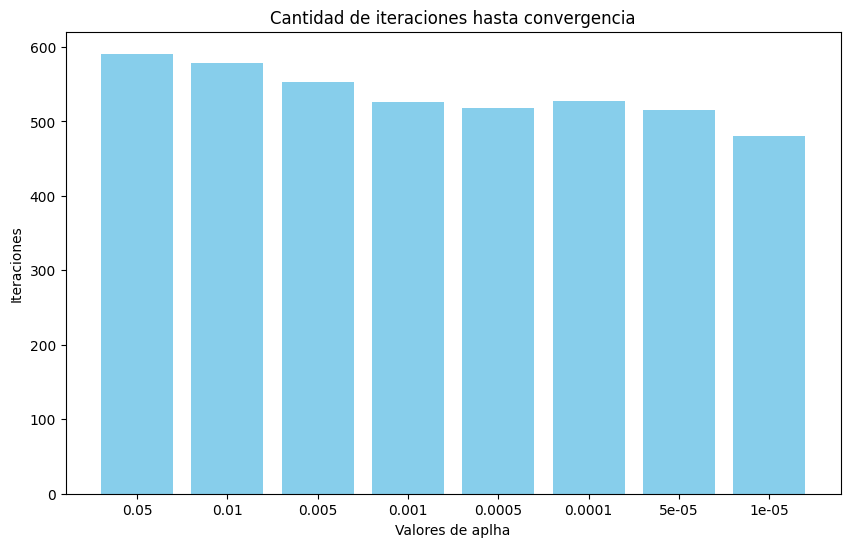

In [28]:
#Tiempos de ejecucion para cada alpha
plt.figure(figsize=(10, 6))

plt.bar(alphas_str, tiempo_ejecucion, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Tiempo de ejecucion (segundos)')
plt.title('Tiempos de ejecucion para cada alpha')

plt.show()

#Progresion del alpha segun el punto de inicio
plt.plot(alphas_str, alphas_nuevos_valores, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Valores finales de alpha')
plt.title('Progresion del alpha segun el punto de inicio')

plt.grid(True) 
plt.show()

#Cantidad de iteraciones hasta convergencia
plt.figure(figsize=(10, 6))
plt.bar(alphas_str, epochs, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Iteraciones')
plt.title('Cantidad de iteraciones hasta convergencia')

plt.show()

El mejor valor de alpha es 0.05 ya que este genera el nuevo valor de alpha mas chico en la menor cantidad de tiempo

## Ejercicio 5

¿Como impacta el tamaño del escalado de las imagenes en la efectividad del metodo? ¿Y en el tiempo de computo?. Realizar los experimentos y graficos acordes para estudiar estas limitaciones.

In [31]:
def probar_escalados(esclados):
    tiempo_ejecucion_esclado = []
    efectividad_training = []
    efectividad_testing = []
    errors_escalado = []

    for i in esclados:
        img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/',i)
        img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/',i) 
        img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/',i)
        img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/',i)

        data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)
        
        data = balancear_datos(data)
        
        train_sin, train_con, test_sin, test_con = data
        training_data = (train_sin,train_con)
        testing_data = (test_sin,test_con)
        
        start_time = time.time()
        
        w_res, b_res = train(
            training_data,
            alpha=0.05,
            epochs=600,
            seed = 42
            )
        
        end_time = time.time()
        
        tiempo_ejecucion_esclado.append(end_time - start_time)
        efectividad_testing.append(test(w_res,b_res,testing_data))
        efectividad_training.append(test(w_res,b_res,training_data))
        errors_escalado.append(error_cuadratico(testing_data,w_res,b_res))
    
    return tiempo_ejecucion_esclado,efectividad_testing,efectividad_training,errors_escalado
    

[0.15522437]

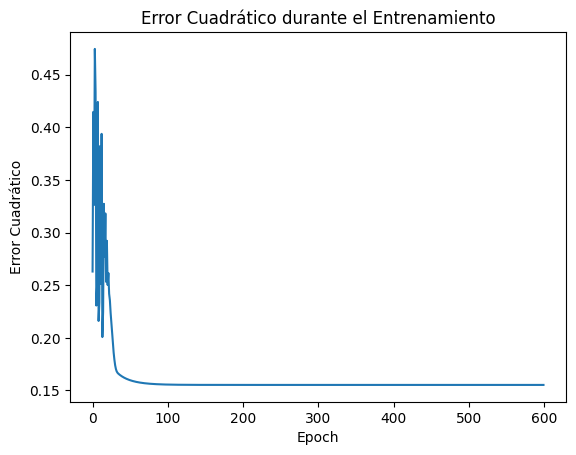

[0.49998924]

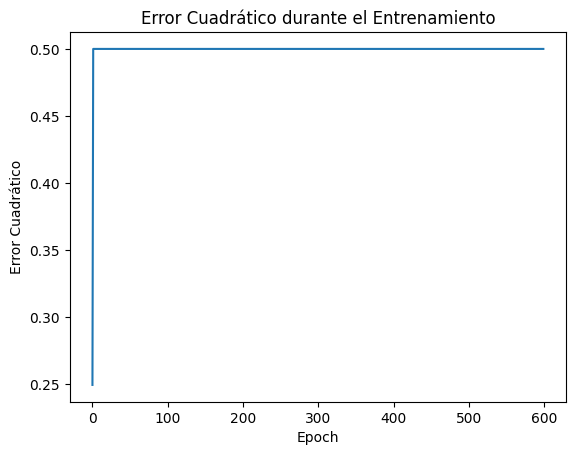

[0.4999985]]

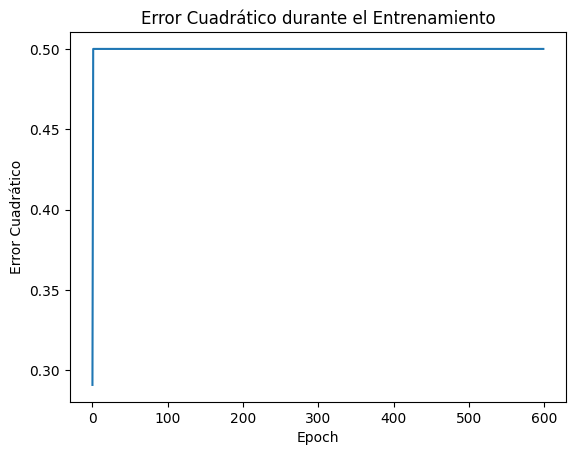

In [32]:
esclados = [32,64,128]
tiempo_ejecucion_esclado,efectividad_testing,efectividad_training,errors_escalado = probar_escalados(esclados)

### Graficos

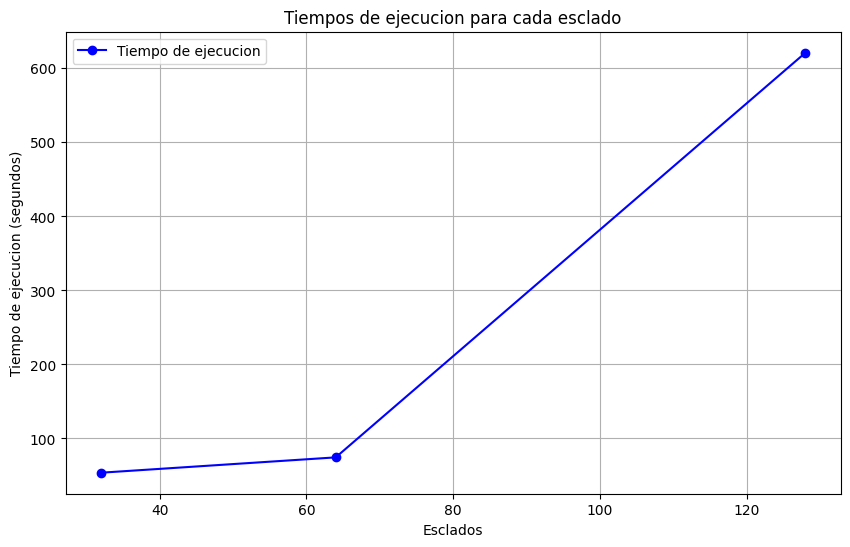

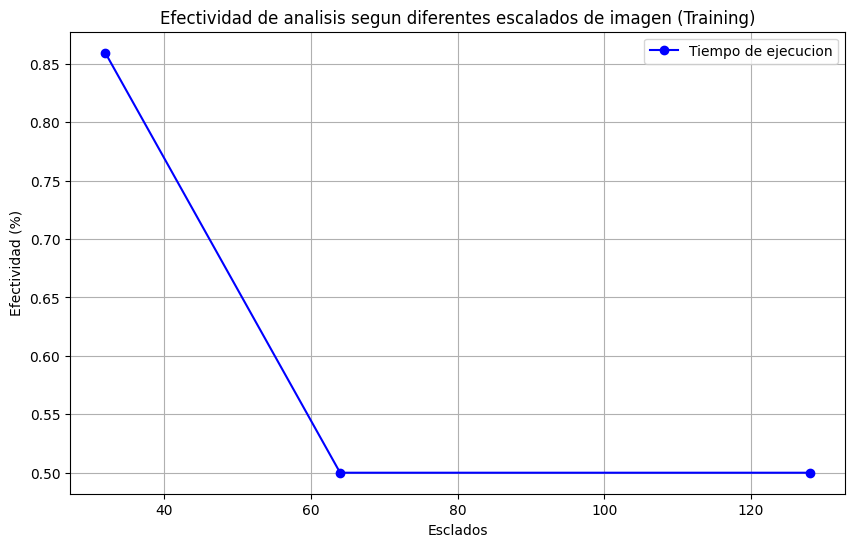

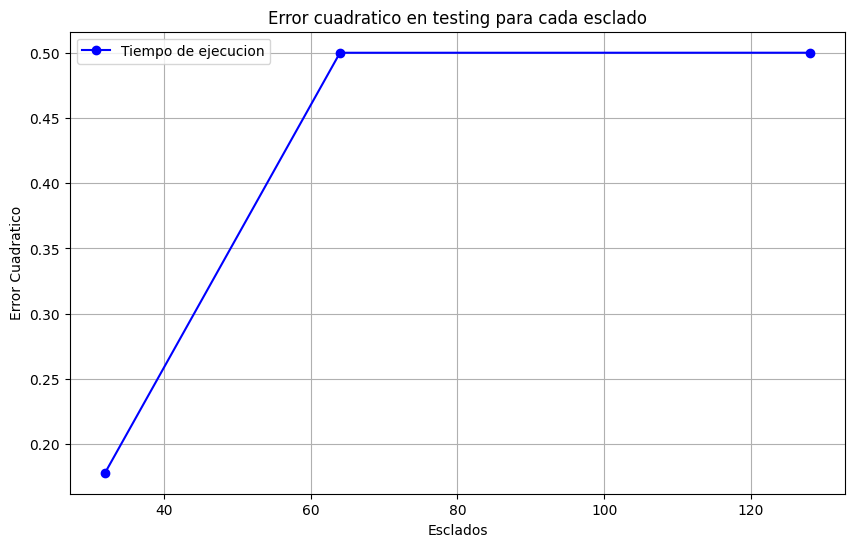

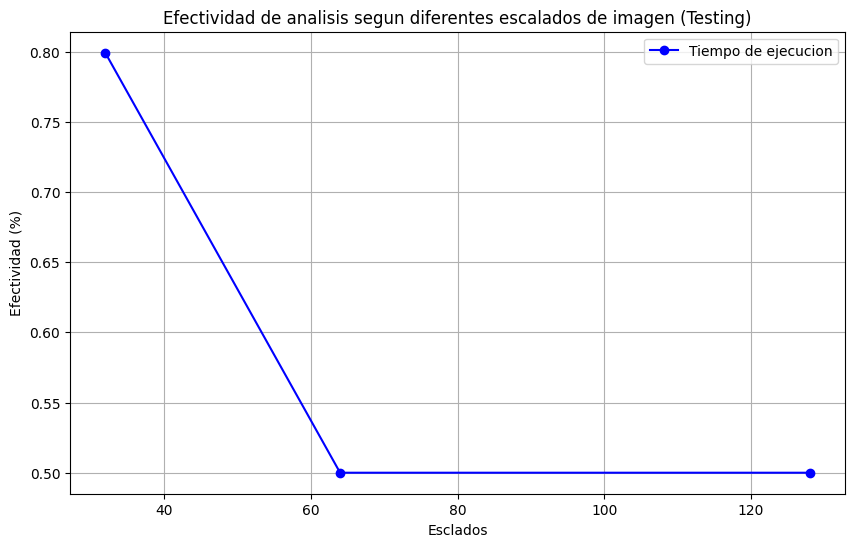

In [33]:
### graficos training
#Tiempos de ejecucion para cada esclado
plt.figure(figsize=(10, 6))

plt.plot(esclados, tiempo_ejecucion_esclado, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Tiempo de ejecucion (segundos)')
plt.title('Tiempos de ejecucion para cada esclado')
plt.legend()  
plt.grid(True) 
plt.show()

#Efectividad para el escalado
plt.figure(figsize=(10, 6))

plt.plot(esclados, efectividad_training, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad de analisis segun diferentes escalados de imagen (Training)')
plt.legend()  
plt.grid(True) 
plt.show()

#### Graficos testing
#errors para el escalado
plt.figure(figsize=(10, 6))

plt.plot(esclados, errors_escalado, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Error Cuadratico')
plt.title('Error cuadratico en testing para cada esclado')
plt.legend()  
plt.grid(True) 
plt.show()

#Efectividad para el escalado
plt.figure(figsize=(10, 6))

plt.plot(esclados, efectividad_testing, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad de analisis segun diferentes escalados de imagen (Testing)')
plt.legend()  
plt.grid(True) 
plt.show()

## Ejercicio 6 

Para el valor de α que tenga mejor valor de convergencia, generar la matriz de confusion y analizar brevemente la efectividad del metodo.

In [34]:
def matriz_de_confusion(datos, w, b):
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    len_datos = len(datos)
    
    Verdadero_Positivo = 0
    Falso_Negativo = 0
    Verdadero_Negativo = 0
    Falso_Positivo = 0
    
    for i in datos_sin_neumonia:
        if F(i,w,b) < 0.5:
            Verdadero_Negativo += 1
        else:
            Falso_Positivo += 1
            
    for i in datos_con_neumonia:
        if F(i,w,b) >= 0.5:
            Verdadero_Positivo += 1
        else:
            Falso_Negativo += 1
            
    matriz = [[Verdadero_Positivo/len_datos,Falso_Negativo/len_datos],
              [Verdadero_Negativo/len_datos,Falso_Positivo/len_datos]]
    
    return matriz
    

In [35]:
w_res, b_res = train(
    training_data,
    alpha=0.05,
    epochs = 500,
    seed = 42,
    plot_graph=True
    )

matriz_de_confusion_training = matriz_de_confusion(training_data,w_res, b_res)
matriz_de_confusion_testing = matriz_de_confusion(testing_data,w_res, b_res)

print(matriz_de_confusion_training)
print(matriz_de_confusion_testing)

[0.4999985]]

KeyboardInterrupt: 